In [336]:
# Load dependencies
import csv
import pandas as pd
import numpy as np
import os
import gc
import warnings
import itertools as it
import DataProcessFunctions as DP
import PredictionStep1 as pred
import SupportFunctions as supp
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression as lr
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from tensorflow.keras.layers import Dense
from matplotlib.pyplot import cm


%load_ext autoreload
%autoreload 2

np.set_printoptions(suppress=True)
warnings.simplefilter(action='ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Initialize warning log container 
log = list()

In [3]:
# Load Pre-processed data from Data Processing PCA.ipynb
FM_data = pd.read_csv(os.path.dirname(os.getcwd()) + '\\FM2_data.csv')
returns = pd.read_csv(os.path.dirname(os.getcwd()) + '\\returns2_data.csv').set_index(["permno", "date"])
industry_code = pd.read_csv(os.path.dirname(os.getcwd()) + '\\industry2_codes.csv').set_index(["permno", "date"])

supp.downcast(FM_data)
supp.downcast(returns)
supp.downcast(industry_code)

Before downcast: 1.769 GB and float64    102
int64        3
dtype: int64
After downcast: 0.878 GB and float32    102
int32        2
int8         1
dtype: int64
Before downcast: 0.026 GB and float64    1
dtype: int64
After downcast: 0.018 GB and float32    1
dtype: int64
Before downcast: 0.026 GB and float64    1
dtype: int64
After downcast: 0.018 GB and float32    1
dtype: int64


In [4]:
# Set number of iterations
ite = 29 # 30 splits --> iteration = [0;29]

# Initialize arrays to store loss and explained variation
loss = pd.DataFrame(columns = range(ite), index = ["LR", "Lasso", "NN"])
xplained_variation = pd.DataFrame(columns = range(ite), index = ["LR", "Lasso", "NN"])

# Initialize arrays to store annual loss and explained variation
loss_annual = pd.DataFrame(columns = range(ite), index = ["LR", "Lasso", "NN"])
xplained_variation_annual = pd.DataFrame(columns = range(ite), index = ["LR", "Lasso", "NN"])

# Initialize arrays to store predicted and actual returns used in portfolio sorts later
LR_pred_actual = pd.DataFrame()
lasso_pred_actual = pd.DataFrame()
NN_pred_actual = pd.DataFrame()

for i in range(ite):
    
    # Compute training, validation, and test set
    training, validation, test = DP.complete_data_process(industry_code, returns, FM_data, iteration = i)
    
    # Split in X and Y
    training_x, training_y = pred.XY_split(training)
    validation_x, validation_y = pred.XY_split(validation)
    test_x, test_y = pred.XY_split(test)
    
    # Algorithm 1: Simple Linear (PCR in Gu, kelly, and Xiu (2020) due to PCA)
    # Fit model on training set & predict on test set
    LR = lr().fit(training_x, training_y)
    LR_pred = LR.predict(test_x)
    
    # Algoritm 1: Compute loss and explained varation, and combine 
    # actual and predicted returns. Append all. 
    LR_loss, LR_explained_var, LR_pred_actual_temp, LR_loss_annual, LR_explained_var_annual = pred.to_append(LR_pred, test_y)
    loss.iloc[0, i] = LR_loss
    loss_annual.iloc[0, i] = LR_loss_annual
    xplained_variation.iloc[0, i] = LR_explained_var
    xplained_variation_annual.iloc[0, i] = LR_explained_var_annual
    LR_pred_actual = LR_pred_actual.append(LR_pred_actual_temp)
    
    
    # ALgorithm 2: LASSO
    # Fit model on training set and select tuning parameter based on validation set
    lambda_grid = pred.lambda_grid(training_x, training_y)
    loss_validation = []

    for lamb in lambda_grid:
        lasso = Lasso(alpha = lamb, tol = 0.001).fit(training_x, training_y)
        lasso_pred = lasso.predict(validation_x)
        loss_validation.append(pred.loss_function(lasso_pred, validation_y))

    # Fit model with error minimizing tuning parameter
    lambda_min = lambda_grid[loss_validation.index(min(loss_validation))]
    lasso_min = Lasso(alpha = lambda_min).fit(training_x, training_y)
    lasso_min_pred = lasso_min.predict(test_x)

    # Algorithm 2: Appending 
    lasso_loss, lasso_explained_var, lasso_pred_actual_temp, lasso_loss_annual, lasso_explained_var_annual = pred.to_append(lasso_min_pred, test_y)
    loss.iloc[1, i] = lasso_loss
    loss_annual.iloc[1, i] = lasso_loss_annual
    xplained_variation.iloc[1, i] = lasso_explained_var
    xplained_variation_annual.iloc[1, i] = lasso_explained_var_annual
    lasso_pred_actual = lasso_pred_actual.append(lasso_pred_actual_temp)
    
    
    # ALgorithm 3: NN 
    # Arkitektur skal gøres uden for loopet! Skal jeg gøre NN mere avanceret? Jeg har stadig linear som de sidste lag også 
    # Build NN architecture 
    model = tf.keras.models.Sequential()
    model.add(Dense(units = 32, activation = 'relu', input_dim = len(training_x.columns))) # 1. Hidden layer
    model.add(Dense(units = 16, activation = 'relu')) # 2. Hidden layer
    model.add(Dense(units = 8, activation = 'relu')) # 3. Hidden layer
    model.add(Dense(units = 4, activation = 'relu')) # 4. Hidden layer
    model.add(Dense(units = 1, activation = 'linear')) # Output layer - linear fixes nonnegative predictions

    # Compile model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error') # jeg kan også bruge huber loss ved 'huber'

    # Fit model
    model.fit(training_x, training_y, epochs = 1, batch_size = 40, verbose = 1)

    # Compute predictions
    NN_pred = model.predict(test_x)
    
    # Appending
    NN_loss, NN_explained_var, NN_pred_actual_temp, NN_loss_annual, NN_explained_var_annual = pred.to_append(NN_pred, test_y)
    loss.iloc[2, i] = NN_loss
    loss_annual.iloc[2, i] = NN_loss_annual
    xplained_variation.iloc[2, i] = NN_explained_var
    xplained_variation_annual.iloc[2, i] = NN_explained_var_annual
    NN_pred_actual = NN_pred_actual.append(NN_pred_actual_temp)
    
    del training
    del validation
    del test
    del training_x
    del training_y
    del validation_x
    del validation_y
    del test_x
    del test_y
    
    gc.collect()

In [7]:
loss.mean(axis = 1)

LR       0.056840
Lasso    0.049465
NN       0.054270
dtype: float64

In [9]:
xplained_variation.mean(axis = 1)

LR      -0.182407
Lasso    0.002578
NN      -0.119037
dtype: float64

In [11]:
loss_annual.mean(axis = 1)

LR       0.950963
Lasso    0.546140
NN       0.905565
dtype: float64

In [13]:
xplained_variation_annual.mean(axis = 1)

LR      -0.948905
Lasso   -0.036715
NN      -0.850638
dtype: float64

In [329]:
# Return for each decile at all points in time
LR_step_1 = pred.portfolio_sorts_1(LR_pred_actual)
lasso_step_1 = pred.portfolio_sorts_1(lasso_pred_actual)
NN_step_1 = pred.portfolio_sorts_1(NN_pred_actual)

# Accumualtive return of all deciles for both
# predicted and actual returns 
LR_cum = pred.portfolio_sorts_acc_return(LR_step_1)
lasso_cum = pred.portfolio_sorts_acc_return(lasso_step_1)
NN_cum = pred.portfolio_sorts_acc_return(NN_step_1)

# Monthly average return and std. deviation, and annualized SR
# of both predicted and actual returns
LR_mean, LR_std, LR_sr = pred.portfolio_sorts_SR(LR_step_1)
lasso_mean, lasso_std, lasso_sr = pred.portfolio_sorts_SR(lasso_step_1)
NN_mean, NN_std, NN_sr = pred.portfolio_sorts_SR(NN_step_1)

In [339]:
# Cumulative return figures 
pred.cumulative_ret_fig(data = LR_step_1, name = "LR_cumulative_ret", save_fig = True, hide = True)
pred.cumulative_ret_fig(data = lasso_step_1, name = "lasso_cumulative_ret", save_fig = True, hide = True)
pred.cumulative_ret_fig(data = NN_step_1, name = "NN_cumulative_ret", save_fig = True, hide = True)

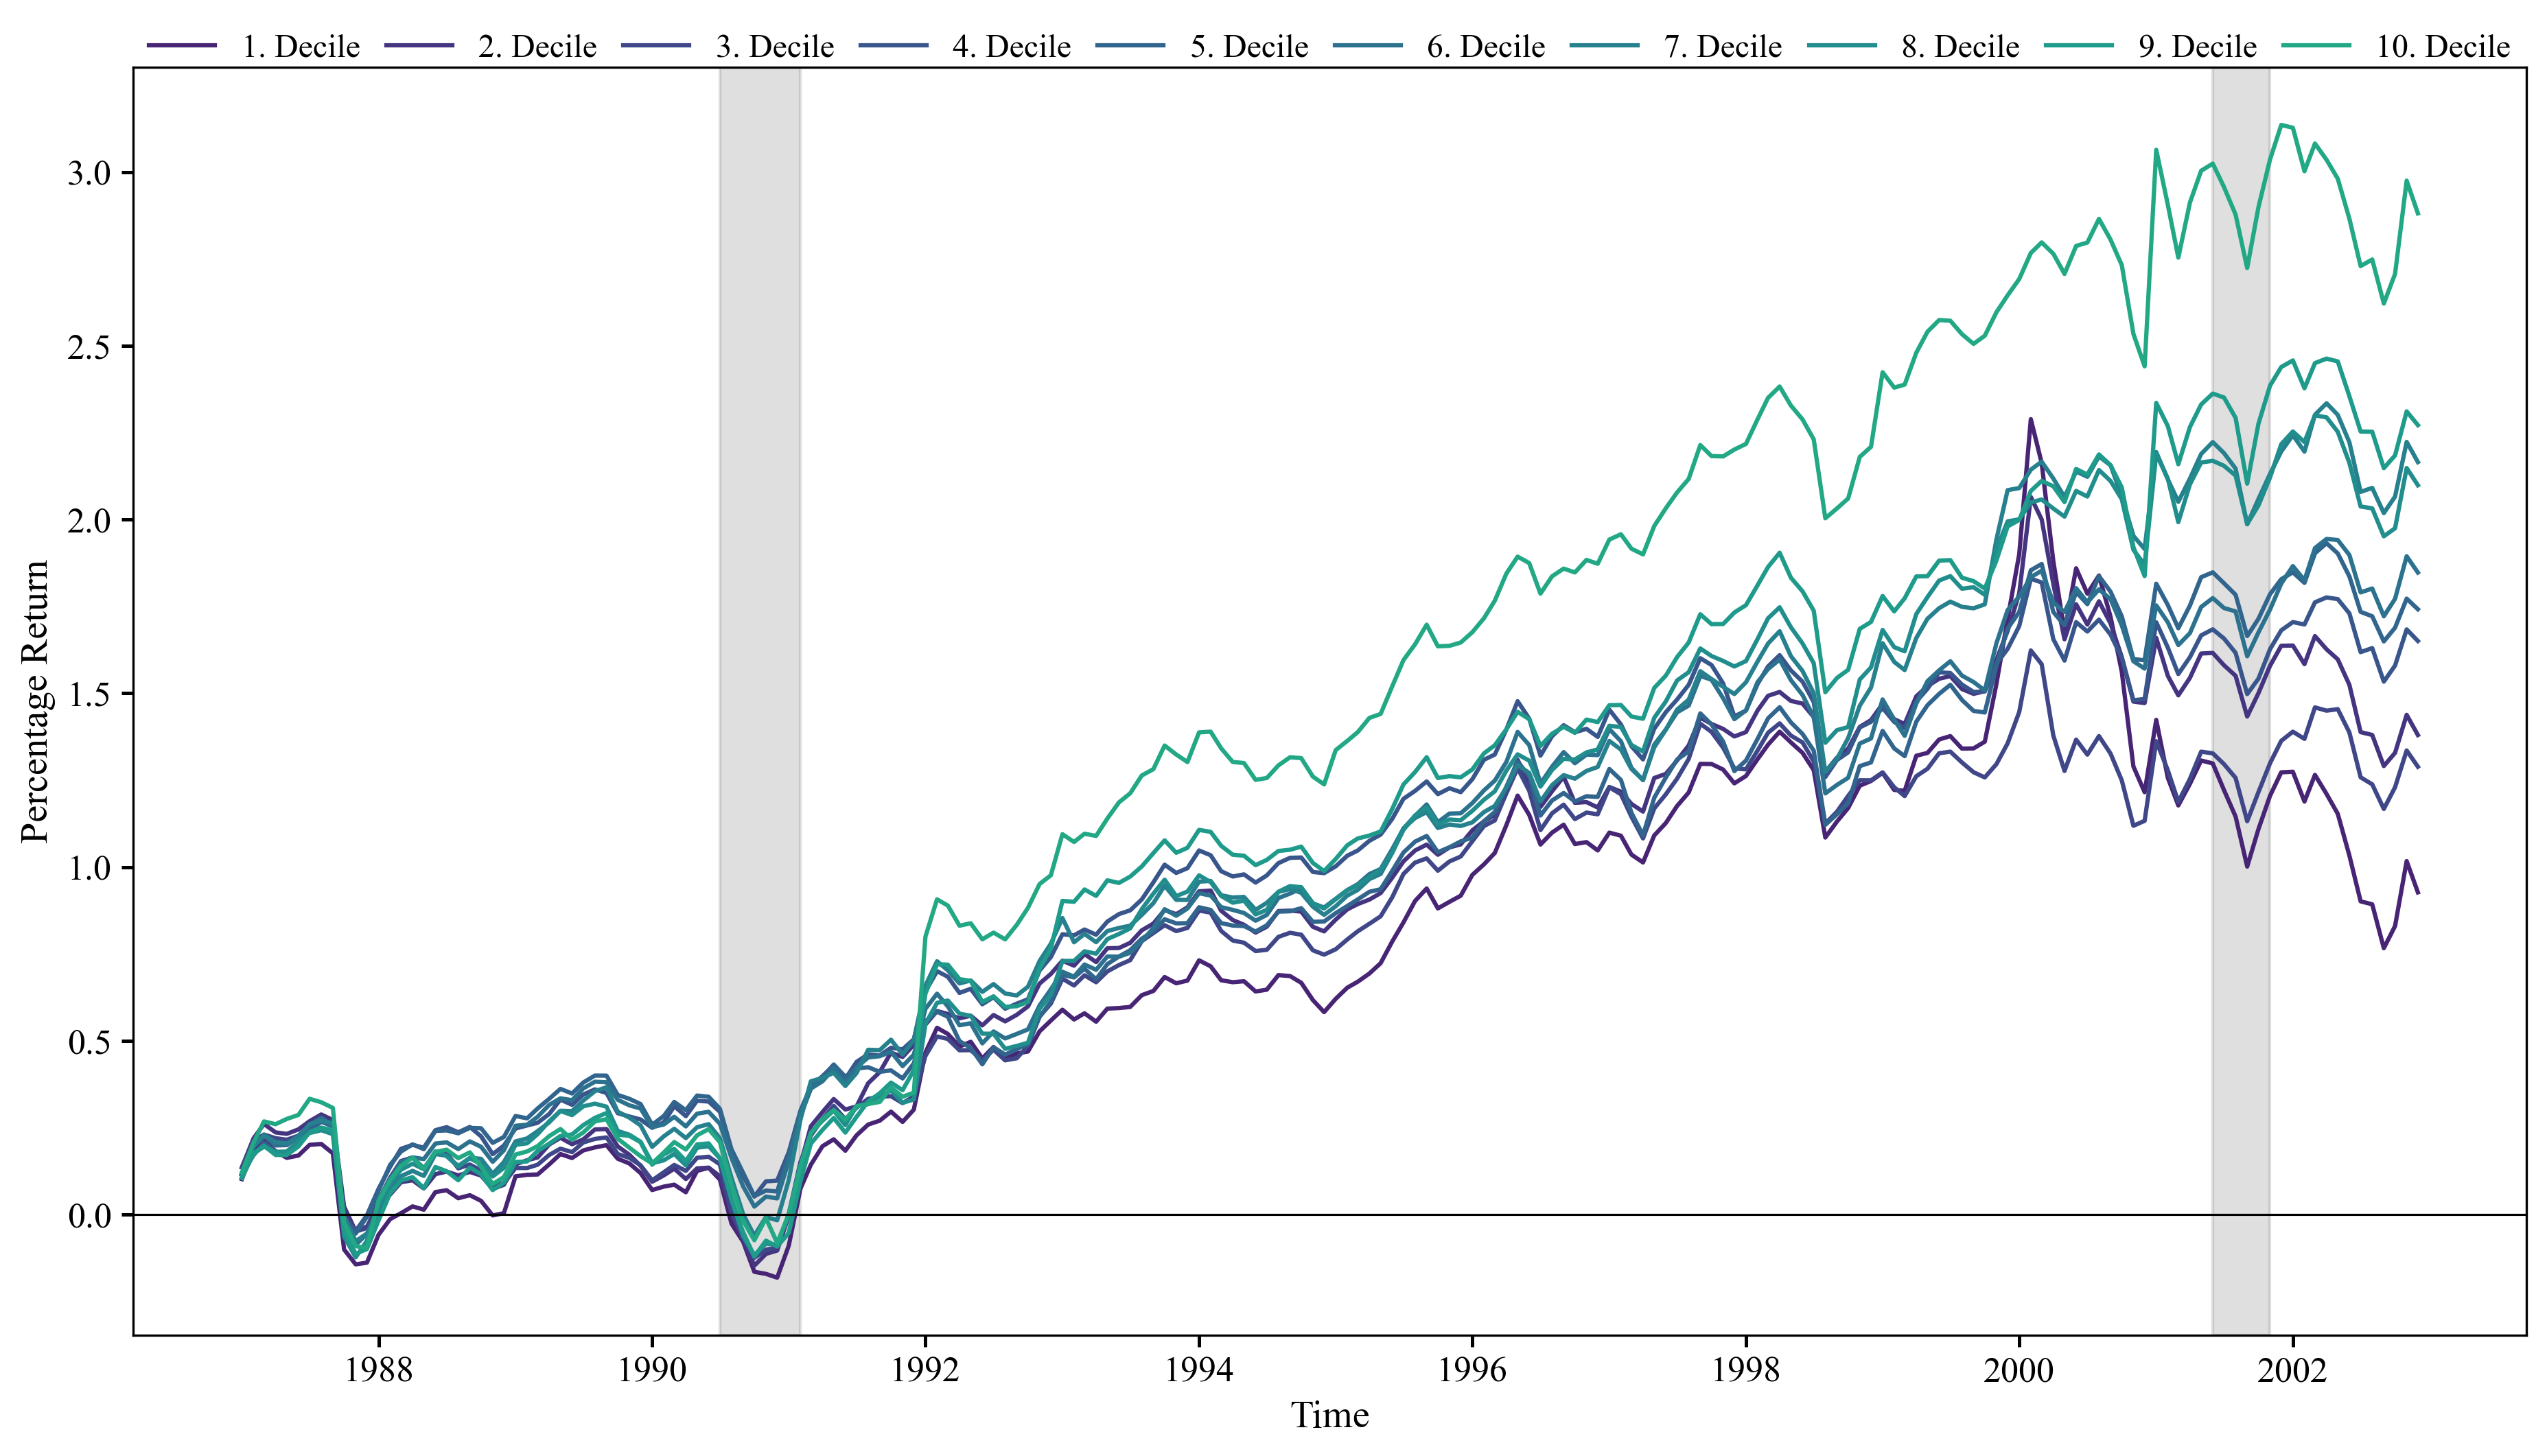

In [322]:
# Figur - denne figru bliver alle 10 deciler for en model. Jeg kan gøre det for hver model. Jeg skal dog også have figuren hvor jeg har 10. og 1. decil for alle modeller. Den kan jeg laver nedenunder
# dataen jeg skal bruge kan jeg få på samme approach som her, jeg skal bare kune vælge for x in [1, 11] i stedet for x in range (1, 11)

# Nu sætter jeg figuren op til en enkelt model, så kan jeg tilføje loop bagefter og gøre det for alle modeller 

# running cumulative returns for 1 model
figure_data = [list(it.accumulate(step_1[step_1.index.get_level_values(1) == x].ret)) for x in range(1, 11)]
# dates 
dates = list(step_1.index.get_level_values(0).unique())
dates = pd.to_datetime(dates, format = '%Y%m')

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Times New Roman"

n = len(figure_data)



fig, ax = plt.subplots(figsize = (15,8))

color = iter(cm.viridis(np.linspace(0.1, 0.6, n)))
label = iter([f'{ite}.' + ' Decile' for ite in range(1, n+1)])

for i in range(n):
    
    c = next(color)
    l = next(label)
    
    ax.plot(date, 
            figure_data[i], 
            c = c, 
            label = l);

# Add labels and change font 
plt.xlabel("Time", size = 13.5)
plt.ylabel("Percentage Return", size = 13.5)

ax.legend(loc = 'upper center', ncol = 10, bbox_to_anchor = (0.5, 1.05), fontsize = 11.5, columnspacing=0.8, frameon=False)

ax.axhline(y=0, color='black', linewidth=0.75)  
#ax.axhline(y=1, color='black', linewidth=0.5)  
#ax.axhline(y=2, color='black', linewidth=0.5)  
#ax.axhline(y=3, color='black', linewidth=0.5)  

# Smaller tick text and smaller ticks
ax.tick_params(axis='both', which='major', labelsize=12.5, width = 1.2, length = 4)

R1_start = pd.datetime(1990, 7, 1)
R1_end = pd.datetime(1991, 2, 1)
plt.axvspan(R1_start, R1_end, color="grey", alpha=0.25)

R2_start = pd.datetime(2001, 6, 1)
R2_end = pd.datetime(2001, 11, 1)
plt.axvspan(R2_start, R2_end, color="grey", alpha=0.25)


# Save as PDF
plt.savefig('figur_test.pdf', bbox_inches='tight')

plt.show()

# smid det her ind i en funktion? input: data, titel til figur, dummy for om man vil save eller bare vise? 

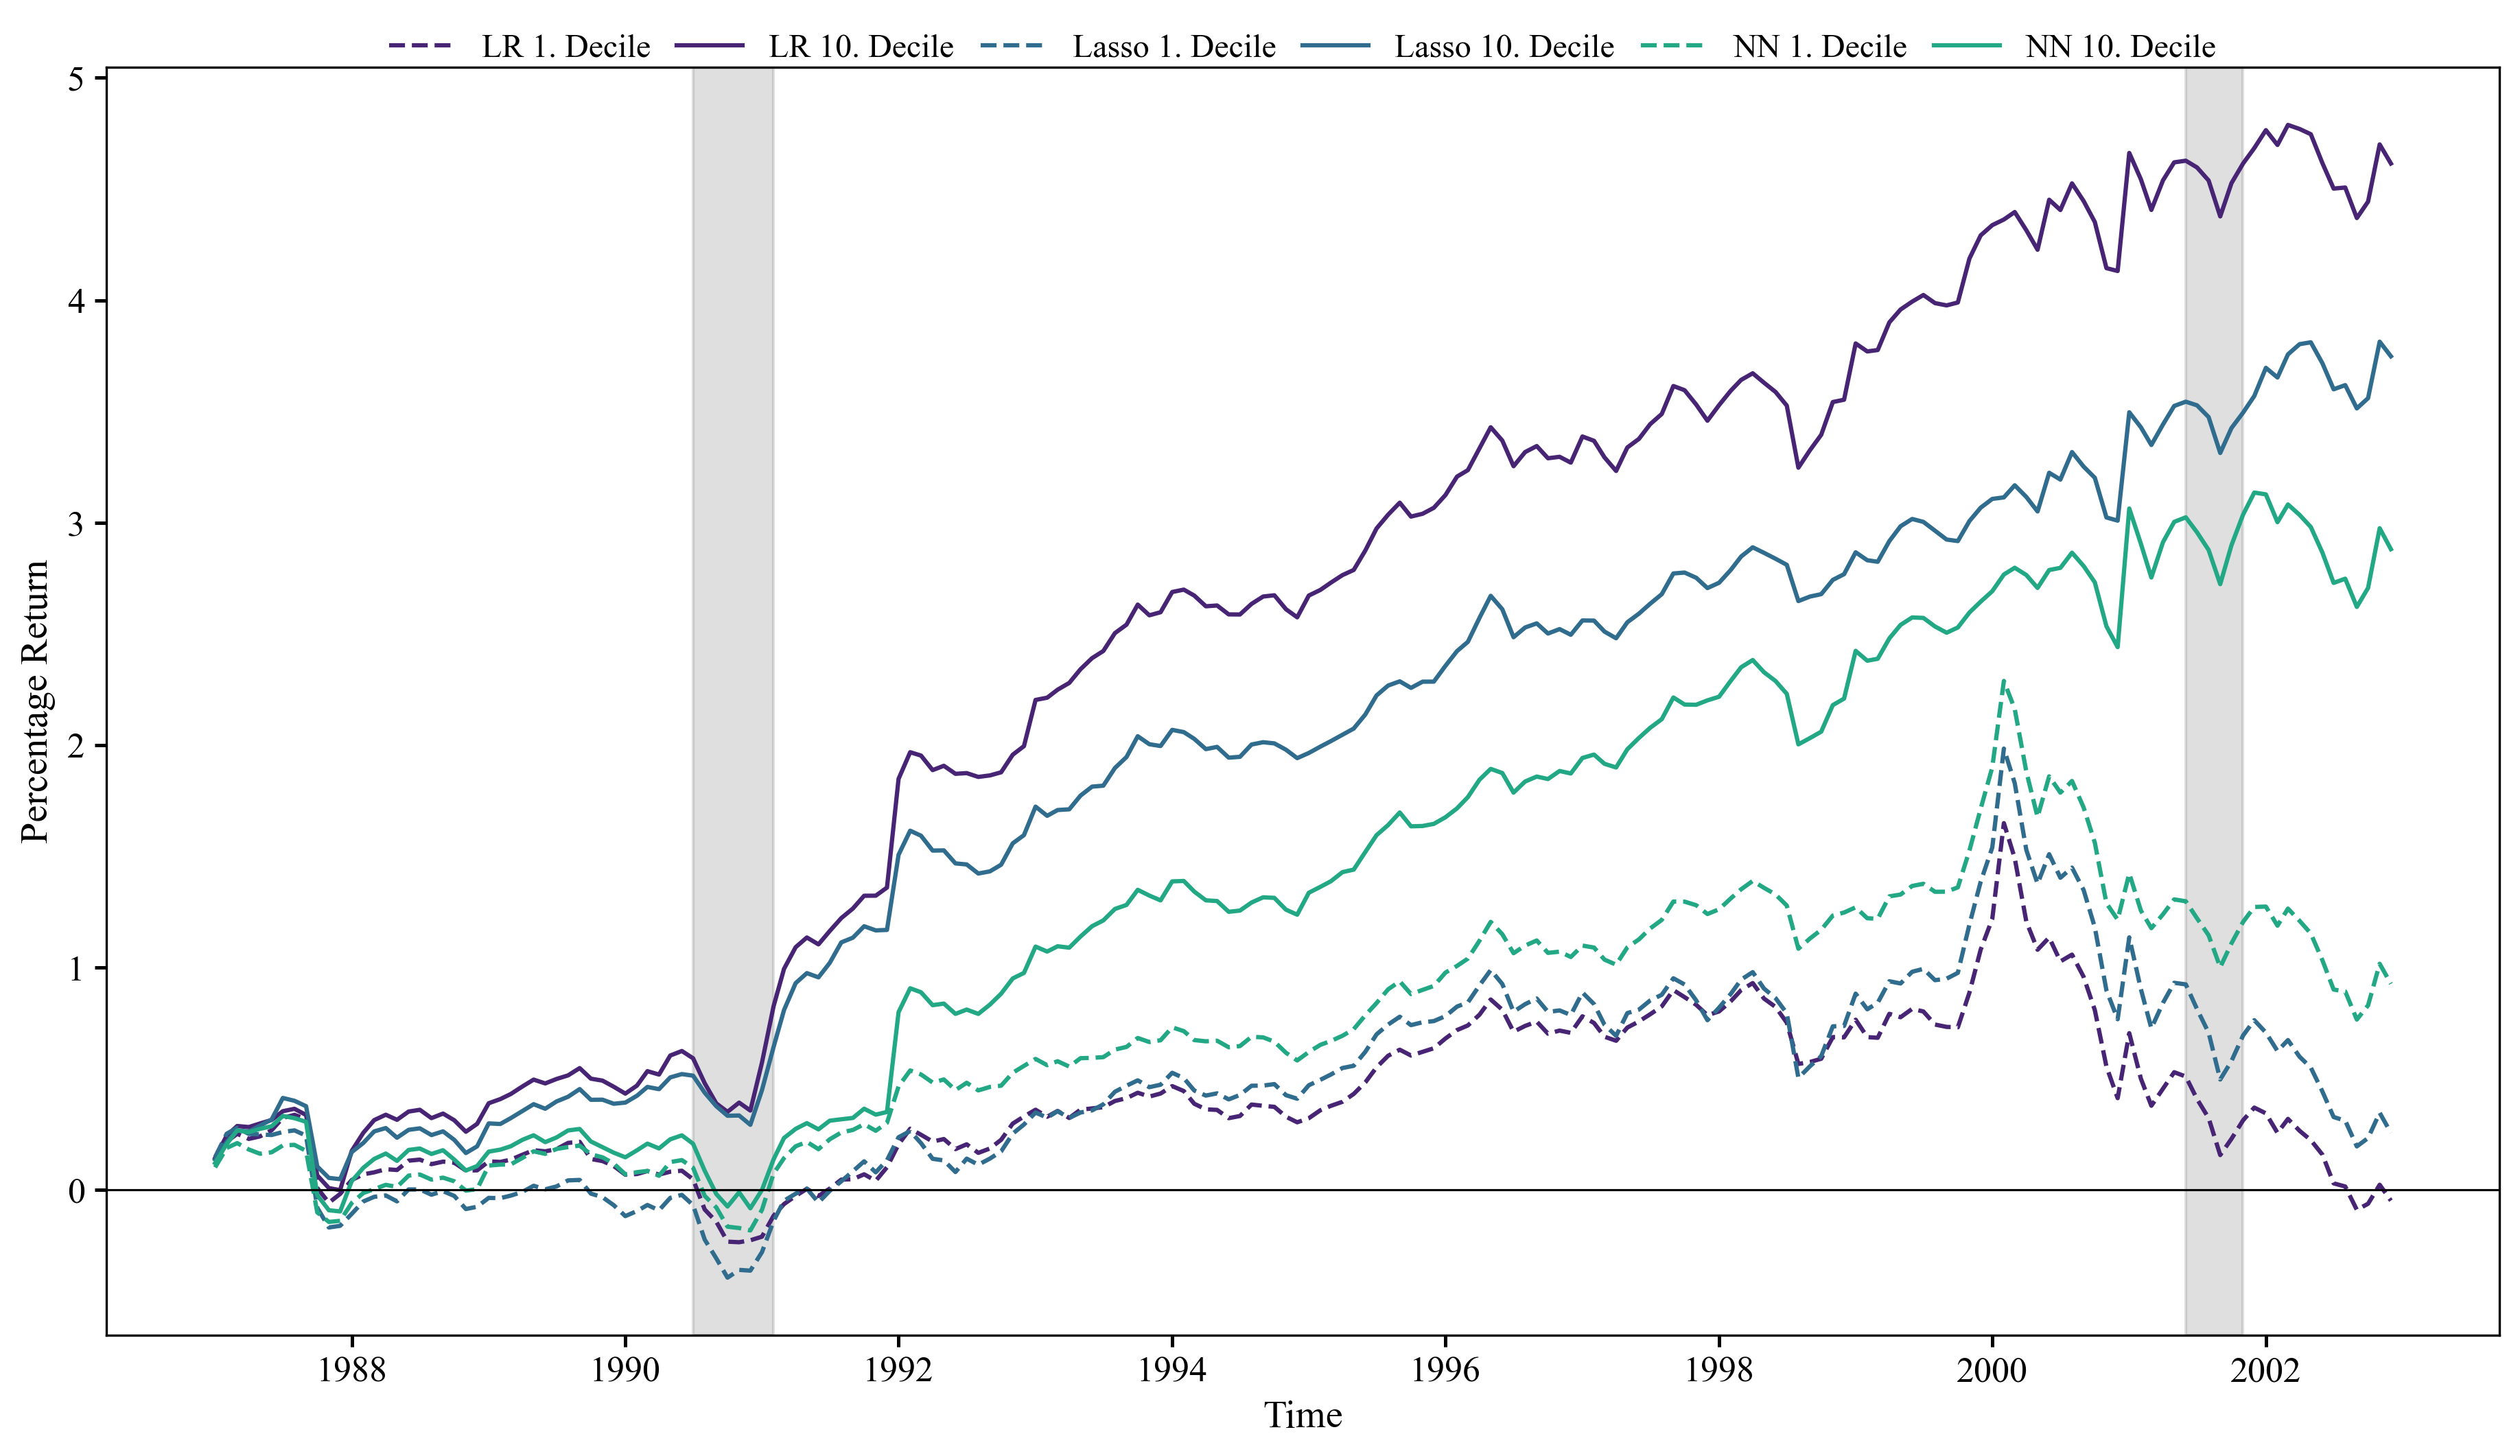

In [361]:
# I morgen skal jeg have gjort starten her smarter; skal kunne virkelig lige meget hvor mange ML modellers datas jeg feeder den 

# running cumulative returns for 1 model
LR_figure_data = [list(it.accumulate(LR_step_1[LR_step_1.index.get_level_values(1) == x].ret)) for x in [1, 10]]
lasso_figure_data = [list(it.accumulate(lasso_step_1[lasso_step_1.index.get_level_values(1) == x].ret)) for x in [1, 10]]
NN_figure_data = [list(it.accumulate(NN_step_1[NN_step_1.index.get_level_values(1) == x].ret)) for x in [1, 10]]
data = [LR_figure_data, lasso_figure_data, NN_figure_data]
# dates 
dates = list(LR_step_1.index.get_level_values(0).unique())
dates = pd.to_datetime(dates, format = '%Y%m')

plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "Times New Roman"

n = len(data)



fig, ax = plt.subplots(figsize = (15,8))

color = iter(cm.viridis(np.linspace(0.1, 0.6, n)))
label = iter(["LR 1. Decile", "LR 10. Decile", "Lasso 1. Decile", "Lasso 10. Decile", "NN 1. Decile", "NN 10. Decile"])

for i in range(n):
    
    c = next(color)
    l = next(label)
    
    ax.plot(dates, 
            data[i][0], 
            c = c, 
            label = l, 
            linestyle = "dashed");
    
    l = next(label)
    
    ax.plot(dates, 
            data[i][1], 
            c = c, 
            label = l);

# Add labels and change font 
plt.xlabel("Time", size = 13.5)
plt.ylabel("Percentage Return", size = 13.5)

ax.legend(loc = 'upper center', ncol = 10, bbox_to_anchor = (0.5, 1.05), fontsize = 11.5, columnspacing=0.8, frameon=False)

ax.axhline(y=0, color='black', linewidth=0.75)  
#ax.axhline(y=1, color='black', linewidth=0.5)  
#ax.axhline(y=2, color='black', linewidth=0.5)  
#ax.axhline(y=3, color='black', linewidth=0.5)  

# Smaller tick text and smaller ticks
ax.tick_params(axis='both', which='major', labelsize=12.5, width = 1.2, length = 4)

R1_start = pd.datetime(1990, 7, 1)
R1_end = pd.datetime(1991, 2, 1)
plt.axvspan(R1_start, R1_end, color="grey", alpha=0.25)

R2_start = pd.datetime(2001, 6, 1)
R2_end = pd.datetime(2001, 11, 1)
plt.axvspan(R2_start, R2_end, color="grey", alpha=0.25)


# Save as PDF
plt.savefig('10_1_decils.pdf', bbox_inches='tight')

plt.show()

# Skal nok have samme model = samme farve men den ene decil må så være dashed eller lignende 

In [ ]:
# Tror jeg skal dele portfolio sorts ind i 2 dele (2 funktinoer). Jeg har den første nu, som for hver periode hver decil spytter returns ud. Derfra skal jeg så bruge det output til 2 forskellige ting.
# 1) Jeg skal akkumulere returns over perioden for hver decil, så jeg ender med at kumulativt return for hver decil, i.e. 10 tal
# 2) For at lave figur A.7 i gu, kelly xiu appendix + for at regne sharpe ratio ud, så skal jeg bruge returns for hver decil i hver periode. For at lave figuren skal jeg til hver periode akkumulere returns a la hvad jeg 
# gjorde for PCA figuren. For at regne sharpe ratio ud skal jeg for hver decil over perioden finde average return og std. dev. 

In [ ]:
# Portfolio sorts; groupby dato. for hver gruppe splitter vi nu preds op i deciler og calculater return for hver portefølje (på det faktiske return). Vi gør dette for hver måned og så får vi så efter et år 12 observationer
# for hver portefølje, vi kan nu calculate sharpe ratio for hver a porteføljerne (mobthly sharpe ratio) baseret på det ene år, hvis vi nu har længere periode kan jeg compoute monthly sharpe ratio på den længere periode, man kan så
# annualize ved at gange med sqrt(12). 

# hvad siger gu kelly og xiu om portfolio sorts hvad gør de? 

# det kunne være sjovt at sammenligne med konventielle asset pricing modeller som f.eks. FF3 og CAPM -- gør de vel egentlig ogsåi  gu kelly og xiu 


# jeg skal have ryddet op i koden med loopet. både NN struktur men også bare resten generelt 
# Skal jeg lave en normals OLS på ikke PCA data? bare som totalt benchmark? 

# jeg skal lave gu kelly xiu tabel 7 -- er der andre tabeller jeg skal have med? Jeg tænker at eksportere relevant data (i korrekt format) til R, så jeg kan bruge table-theme jeg har lavet der